# Download required modules

In [1]:
!pip install diffusers
!pip install transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 9.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinu

# Inference

Set to CUDA

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Load Model

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from diffusers import UNet2DModel, DDIMScheduler, VQModel

unet = UNet2DModel.from_pretrained("/content/drive/MyDrive/LDM_Test", subfolder="unet")
vqvae = VQModel.from_pretrained("/content/drive/MyDrive/LDM_Test", subfolder="vqvae")
scheduler = DDIMScheduler.from_config("CompVis/ldm-celebahq-256", subfolder="scheduler")

unet.to(device)
vqvae.to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)

scheduler/scheduler_config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


VQModel(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1):

Inference

In [5]:
import PIL.Image
import numpy as np
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps=200)

seed = 0

generator = torch.manual_seed(seed)
noise = torch.randn(
    (1, unet.config.in_channels, unet.config.sample_size, unet.config.sample_size),
    generator=generator,
).to(device)

image = noise
for t in tqdm(scheduler.timesteps):
    # Predict Noise Residual
    with torch.no_grad():
        residual = unet(image, t)["sample"]

    # Compute Previous Image
    prev_image = scheduler.step(residual, t, image)["prev_sample"]
    image = prev_image

# Decode Image
with torch.no_grad():
  image = vqvae.decode(image)

image = image.sample

# Process Image
image_processed = image.cpu().permute(0, 2, 3, 1)
image_processed = (image_processed + 1.0) * 127.5
image_processed = image_processed.clamp(0, 255).numpy().astype(np.uint8)
image_pil = PIL.Image.fromarray(image_processed[0])
image_pil.save('generated_image.jpg')

  0%|          | 0/200 [00:00<?, ?it/s]

# Visualization

In [6]:
import os
import cv2
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

preprocess = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def filter_class(dataset, class_label):
    indices = [i for i, target in enumerate(dataset.targets) if target == class_label]
    return Subset(dataset, indices)

class_label = 3

dataset = datasets.CIFAR10(root='data_test', train=False, download=True, transform=preprocess)
filtered_dataset = filter_class(dataset, class_label)
dataloader = DataLoader(filtered_dataset, batch_size=1, shuffle=True)
features, labels = next(iter(dataloader))

for batch_idx, (images, labels) in enumerate(dataloader):
    if batch_idx >= 1:
        break
    for idx, image in enumerate(images):
        image = image.permute(1, 2, 0).numpy()
        image = (image * 255).astype('uint8')
        cv2.imwrite('real_image.jpg', image)

100%|██████████| 170498071/170498071 [00:18<00:00, 9255180.82it/s]


Extracting data_test/cifar-10-python.tar.gz to data_test


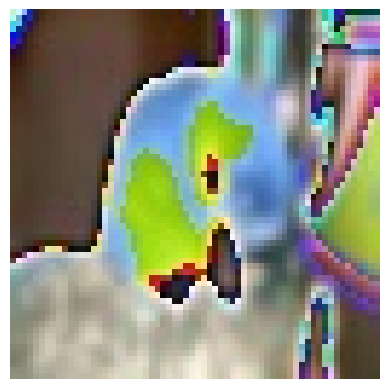

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('real_image.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

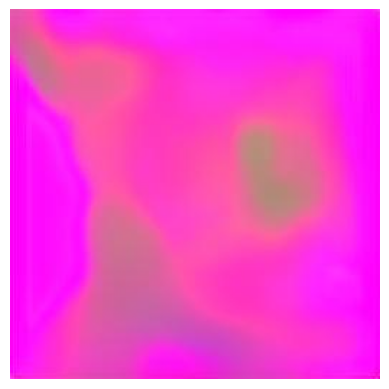

In [8]:
img = mpimg.imread('generated_image.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()